# Project 11 - Building a low volatility indicator of Chinese A-stocks
### Background
Low volatility can be a very effective predictor for future returns in China A- shares market.  However, we have observed that we need to carefully understand and build a low volatility signal that is indicative of not only a stock’s current volatility, but also its future volatility. 

[MSCI Article](https://www.msci.com/www/blog-posts/how-the-low-volatility-factor/01132841955)

### Aim & deliverables
We would like to build a company-level predictive model for identifying stocks with low future volatility. We will look to combine company fundamental data (from the income statement and balance sheet) with trailing volatility and return information to build a better forecast for future volatility of a company.

In [133]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

dateparser = lambda x: pd.datetime.strptime(x, "%Y-%m-%d")
china_stocks = pd.read_csv('China_A_200101_201906.csv', parse_dates=['py_month_end'], date_parser=dateparser)
china_stocks.head()

,cxrf,total_ror,a_p,accr,agro,aroe,asst_risk,blev,bps,btop_risk,...,pncv_cwcnorm,rasr_cwcnorm,rosa_cwcnorm,rstr_cwcnorm,size_cwcnorm,stvi_cwcnorm,industry_group,economic_sector_group,market,py_month_end
0,3067,0.813327,NaN,NaN,-0.044669,0.173535,5.124846,1.043375,NaN,NaN,...,NaN,0.639191,NaN,-0.242582,-4.713727,0.749794,NaN,NaN,CN,2018-04-30
1,3067,NaN,NaN,NaN,-0.029047,0.171417,5.182524,1.010264,NaN,NaN,...,NaN,0.327125,NaN,NaN,NaN,NaN,NaN,NaN,CN,2018-02-28
2,3067,NaN,NaN,NaN,-0.029047,0.169960,5.135313,1.010264,NaN,NaN,...,NaN,0.339075,NaN,NaN,NaN,-1.307818,NaN,NaN,CN,2017-10-31
3,3067,NaN,NaN,NaN,-0.029047,0.169326,5.138544,1.010264,NaN,NaN,...,NaN,0.342490,NaN,NaN,NaN,NaN,NaN,NaN,CN,2017-11-30
4,3067,NaN,NaN,NaN,-0.029047,0.170520,5.189485,1.010264,NaN,NaN,...,NaN,0.295960,NaN,NaN,NaN,NaN,NaN,NaN,CN,2018-01-31


## Data cleaning

Our data cleaning process consists of
* Changing column data types (e.g. categorical, numeric, binary)
* Removing columns that have little non-NaN values, or little unique data

In [143]:
# Convert data types
china_stocks['cxrf'] = china_stocks.cxrf.astype('category')
china_stocks['economic_sector_group'] = china_stocks.economic_sector_group.astype('category')
china_stocks['industry_group'] = china_stocks.industry_group.astype('category')
china_stocks['market'] = china_stocks.market.astype('category')
china_stocks['returns'] = china_stocks['total_ror'] - 1

In [144]:
columns_to_remove = []

total_rows = china_stocks.shape[0]

for idx, col in china_stocks.iteritems(): 
    unique_entries = col.nunique()
    percentage_of_nonNaN = ((total_rows - col.isna().sum())/total_rows) * 100
    
    if unique_entries < 2 or percentage_of_nonNaN < 0.50:
        print(f'Column:{idx}')
        print(f'Unique entries {col.nunique()}')
        print(f'Non-NaN entries: {((266518 - col.isna().sum())/266518) * 100}',end='\n\n')
        columns_to_remove.append(idx)

china_stocks = china_stocks.drop(columns=columns_to_remove)

Column:a_p
Unique entries 0
Non-NaN entries: 0.0

Column:calf
Unique entries 0
Non-NaN entries: 0.0

Column:a_p_cwcnorm
Unique entries 0
Non-NaN entries: 0.0

Column:accr_cwcnorm
Unique entries 0
Non-NaN entries: 0.0

Column:bps_cwcnorm
Unique entries 0
Non-NaN entries: 0.0

Column:calf_cwcnorm
Unique entries 0
Non-NaN entries: 0.0

Column:cflow_cwcnorm
Unique entries 0
Non-NaN entries: 0.0

Column:rosa_cwcnorm
Unique entries 0
Non-NaN entries: 0.0

Column:market
Unique entries 1
Non-NaN entries: 100.0



## Sampling

1. Because not all companies contain an equal amount of data, we'd like to start by building our model based on companies with a sufficiently large dataset. 

2. In the analysis below, we learn that there is a sizeable amount of companies (632) with a *complete dataset* from January '01 to June '19. 

3. Moving forward, we decided to use these *full data companies* as our sample upon which we will build our model on. 

In [145]:
## Keep the companies with a full data set

# Count the number of occurences of each value (company) in the cxrf col
counts_of_companies = china_stocks['cxrf'].value_counts()

# Number of companies with 222 counts of data
full_data_coy = counts_of_companies[counts_of_companies == counts_of_companies.max()].index.tolist()

# Create new dataframe for companies will full set of data
china_stocks_large = china_stocks.loc[china_stocks['cxrf'].isin(full_data_coy)].reset_index(drop=True)
china_stocks_large.head()

,cxrf,total_ror,accr,agro,aroe,asst_risk,blev,bps,btop_risk,cflow,...,PAIM_cwcnorm,pncv_cwcnorm,rasr_cwcnorm,rstr_cwcnorm,size_cwcnorm,stvi_cwcnorm,industry_group,economic_sector_group,py_month_end,returns
0,3544,0.932785,0.007104,0.076045,0.233325,6.940010,1.295927,1.899177,0.485723,0.133751,...,-0.161009,-0.218481,1.788768,-0.898490,-3.112868,-0.777881,"PHOTOOPTICAL,MICROS,OFFC.MCH.",TECH,2011-05-31,-0.067215
1,3544,0.900325,0.010521,0.076269,0.212320,6.971717,1.292808,1.959875,0.742377,0.138057,...,-0.145678,-0.197752,-0.759962,-1.171224,-3.382034,-0.143845,"PHOTOOPTICAL,MICROS,OFFC.MCH.",TECH,2012-03-31,-0.099675
2,3544,0.956208,0.016860,0.089016,0.196017,6.767115,1.592630,1.692062,0.333740,0.152586,...,-0.203345,-0.311327,1.879610,0.110237,-3.089693,1.368798,"PHOTOOPTICAL,MICROS,OFFC.MCH.",TECH,2010-05-31,-0.043792
3,3544,0.967343,0.014515,0.089016,0.212644,6.770250,1.590266,1.306799,0.288477,0.117374,...,-0.217355,-0.261295,1.783166,0.007341,-2.962512,4.073888,"PHOTOOPTICAL,MICROS,OFFC.MCH.",TECH,2010-08-31,-0.032657
4,3544,1.034951,0.004031,0.282085,0.130918,5.683209,3.060559,1.661175,0.147923,0.277160,...,-0.170353,0.178291,1.051948,-1.059265,-2.889308,0.534240,"PHOTOOPTICAL,MICROS,OFFC.MCH.",TECH,2002-06-30,0.034951


## Defining Volatility
1. We defined volatility as the **standard deviation of the returns** of the stock. 
2. We initially found the volatility for a year (i.e. s.d of Jan - Dec)
3. However, it resulted in less values for us to apply regression methods on; we were dealing with 12 values to 1 volatility value
4. Hence we calculated the **S.D on a moving window (of 12) to calculate the volatility**


In [146]:
from numpy import nanstd

def create_coy_dataset(company_number, export_to_csv=False):
    '''Takes in a company's number and returns a dataframe with the company's information
    sorted according to date, with a rolling standard deviation of 12 months and its difference'''
    output = china_stocks.loc[china_stocks.cxrf == company_number]
    output = output.sort_values('py_month_end')
    returns = output.loc[:, 'returns']
    rolling = returns.rolling(12, min_periods=5).apply(nanstd, raw=False)
    differences = rolling.diff()

    output['rolling_std'] = rolling
    output['std_diff'] = differences
    if export_to_csv:
        output.to_csv(f'coy_{company_number}.csv', index=False)
    return output

## Approach 1: Feature engineering
1. We tried to find features from the other columns to predict the volatility. 
2. However, from the heat map below, we find that the correlation of features varies from company to company, making regression techniques tricky.

### What is the heat map about?
For a single company, we calculated the correlation of all the financial features (e.g. asset risk, btop risk) against volatility. Now we iterated this processes through different companies (30, to be specific). The heat map's columns represents each company, while the rows represent the different financial features' correlation. For instance, cell (x,y) tells us the correlation of company y's volatility against feature x. 

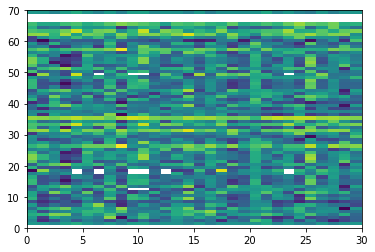

In [147]:
import matplotlib.pyplot as plt

correlation_df = pd.DataFrame(index=china_stocks_large.columns)

def find_corr(df):
    corr = df.corr()
    return corr['rolling_std']

for coy in full_data_coy[:30]:
    df = create_coy_dataset(coy)
    correlation_df[str(coy)] = find_corr(df)

plt.pcolor(correlation_df)
plt.show()

### What this heat map tells us
If a single feature was truly correlated with the volatility (e.g. if asset risk was a good indicator of the company's volatility), then we would find that a feature would be consistently correlated to the volatility across different companies. Translated to the heat map, this would mean an entire row of dark greens. However, we do not find this. 

From here, we concluded our attempt at feature engineering.

## Approach 2: Time series analysis

1. We picked up on the volatility's autocorrelated characteristic. 
2. From there, we looked at building our model based on the lagged values. 
3. Hence, we concluded on using the ARIMA model. 

### Combined ACF plot
We found the ACF figures for each company and aggregated them by mean. The aggregated autocorrelation plot is shown below. 

Text(0.5, 1.0, 'Aggregated ACF plots for volatility')

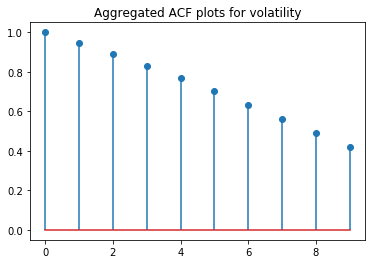

In [148]:
ACF = []

for lag in range(10):
    auto_cor = []
    for coy in full_data_coy[:30]:
        vol = create_coy_dataset(coy).rolling_std
        auto_cor.append(vol.autocorr(lag=lag))
    ACF.append(np.average(auto_cor))
    
plt.stem(ACF, use_line_collection=True)
plt.title('Aggregated ACF plots for volatility')

#### ARIMA model
More details about the ARIMA model and why we chose it can be found in the report. As detailed below, we applied the model by getting it to forecast the next value, and recalibrating the model to the existing values + forecast values.

#### Dummy model
We used the average of the last twelve values to provide a guesstimate of the volatility. 

In [149]:
# Use ARIMA Model
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

def predict_volatility(company_number, print_predictions=False, 
                       print_error=False, print_graph=False, print_residue=False):
    # Split data
    coy = create_coy_dataset(company_number)
    rolling_devs = coy.rolling_std.values[12:]
    split = int(0.8*len(rolling_devs))
    train, test = rolling_devs[0:split], rolling_devs[split:len(rolling_devs)]

    # Create model
    history = [x for x in train]
    predictions = [np.NaN for x in train]
    MSE_anal = []

    # Naive model
    naive = naive_model(train, len(rolling_devs) - split)

    for t in range(len(test)):
        model = ARIMA(history, order=(3, 0, 1))
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        MSE_anal.append(yhat)
        obs = test[t]
        history.append(yhat)
        if print_predictions:
            print('predicted=%f, expected=%f' % (yhat, obs))

    if print_error:
        error = mean_squared_error(MSE_anal, test)
        error_naive = mean_squared_error(naive[-len(test):], test)
        print(f"The mean squared error is {error} for Cxrf {company_number}")
        return error, error_naive

    if print_graph:
        scope = -80
        plt.figure(figsize=(10, 4), dpi=100)
        plt.plot(rolling_devs[scope:], color='black', label='actual')
        plt.plot(predictions[scope:], color='red', label='forecasted')
        plt.plot(naive[scope:], color='blue', label='naive')
        plt.title('Forecast vs Actuals')
        plt.legend(loc='upper left', fontsize=8)
        plt.show()
    
    if print_residue:
        return model_fit.resid
        
        
def naive_model(train, length):
    rep = [np.NaN for x in train]
    mean = np.mean(train[-12:])
    rep.extend([mean for x in range(length)])
    return rep

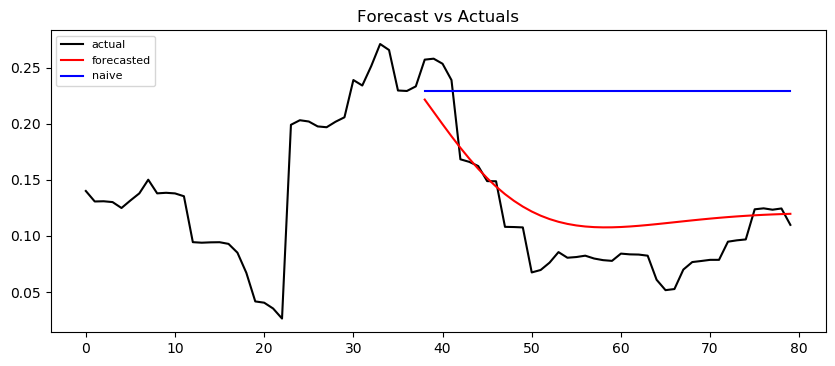

In [150]:
predict_volatility(full_data_coy[30], print_graph=True)

## Analysing our model
This analysis can be done two-fold:
1. Comparing our model vs naive model
2. Finding residual characteristics of ARIMA model

In [151]:
# Finding the mean square error for both naive and ARIMA model

error_1, error_2 = (list(), list())

for idx, company in enumerate(full_data_coy):
    try:
        error_arima, error_naive = predict_volatility(company,print_error=True)
        error_1.append(error_arima)
        error_2.append(error_naive)
    except:
        error_1.append(np.NaN)
        error_2.append(np.NaN)


mse = pd.DataFrame(list(zip(full_data_coy,error_1,error_2)), columns =['Company', 'ARIMA_mse','naive_mse'])

The mean squared error is 0.0010544381661351156 for Cxrf 12816
The mean squared error is 0.003465982600033669 for Cxrf 12707
The mean squared error is 0.0006277763092500574 for Cxrf 9643
The mean squared error is 0.0010409760591040874 for Cxrf 12698
The mean squared error is 0.003557736003773501 for Cxrf 12697
The mean squared error is 0.0012963408523957395 for Cxrf 9644
The mean squared error is 0.0060503704817228485 for Cxrf 12693
The mean squared error is 0.007367106288313337 for Cxrf 9645
The mean squared error is 0.005306462931029114 for Cxrf 12689
The mean squared error is 0.004507179826578351 for Cxrf 12688
The mean squared error is 0.002471197389572043 for Cxrf 9647
The mean squared error is 0.0022888051980631697 for Cxrf 12683
The mean squared error is 0.0008009152392243627 for Cxrf 9648
The mean squared error is 0.0013023879998695855 for Cxrf 9649
The mean squared error is 0.0009453665977696496 for Cxrf 9650
The mean squared error is 0.0018580198738669855 for Cxrf 12674
The m

The mean squared error is 0.0010509780469960411 for Cxrf 9559
The mean squared error is 0.013003307237431146 for Cxrf 12951
The mean squared error is 0.0009905419722279992 for Cxrf 12950
The mean squared error is 0.0007641172014597599 for Cxrf 9560
The mean squared error is 0.008320199622811187 for Cxrf 9561
The mean squared error is 0.003252609498557975 for Cxrf 12944
The mean squared error is 0.0018924117500150688 for Cxrf 9562
The mean squared error is 0.0010014680522644874 for Cxrf 9563
The mean squared error is 0.005356812291779422 for Cxrf 12938
The mean squared error is 0.00525461608487668 for Cxrf 9564
The mean squared error is 0.009397660331227988 for Cxrf 12871
The mean squared error is 0.004793684190147778 for Cxrf 9585
The mean squared error is 0.00268386308372204 for Cxrf 9586
The mean squared error is 0.0016330012745962214 for Cxrf 9609
The mean squared error is 0.004627370799553282 for Cxrf 9611
The mean squared error is 0.0015432554540049169 for Cxrf 9612
The mean squar

The mean squared error is 0.001268106014938692 for Cxrf 9849
The mean squared error is 0.003566129879220436 for Cxrf 7179
The mean squared error is 0.004362286231342026 for Cxrf 7117
The mean squared error is 0.0020303566885458693 for Cxrf 7119
The mean squared error is 0.0018596658298696365 for Cxrf 7130
The mean squared error is 0.0032304713280283106 for Cxrf 7144
The mean squared error is 0.0017043009028322622 for Cxrf 9812
The mean squared error is 0.003526869263857733 for Cxrf 9813
The mean squared error is 0.0020432680711536745 for Cxrf 7149
The mean squared error is 0.0028058881402349225 for Cxrf 7162
The mean squared error is 0.002102007787587404 for Cxrf 7168
The mean squared error is 0.0011312023802471888 for Cxrf 7177
The mean squared error is 0.0008950079077347451 for Cxrf 7180
The mean squared error is 0.004815650010349271 for Cxrf 9850
The mean squared error is 0.0038337355504262103 for Cxrf 7185
The mean squared error is 0.00179379794729374 for Cxrf 9814
The mean squared

The mean squared error is 0.008559192863328744 for Cxrf 13045
The mean squared error is 0.011105383980395893 for Cxrf 13382
The mean squared error is 0.013172988443466285 for Cxrf 13047
The mean squared error is 0.0014825993735824252 for Cxrf 13336
The mean squared error is 0.03347965152543132 for Cxrf 13329
The mean squared error is 0.002470798206485823 for Cxrf 13150
The mean squared error is 0.00173166932412382 for Cxrf 13360
The mean squared error is 0.0019153353914946633 for Cxrf 13028
The mean squared error is 0.0014311155000028568 for Cxrf 8027
The mean squared error is 0.0026249085383534265 for Cxrf 13398
The mean squared error is 0.003076539470982264 for Cxrf 13320
The mean squared error is 0.008039975587849284 for Cxrf 13156
The mean squared error is 0.0026646392925457037 for Cxrf 13327
The mean squared error is 0.0033335652272381716 for Cxrf 13033
The mean squared error is 0.002729992123186738 for Cxrf 9062
The mean squared error is 0.0013337281322707165 for Cxrf 13034
The m

In [157]:
mse

,Company,ARIMA_mse,naive_mse,comparison
0,12816,0.001054,0.001230,ARIMA more accurate
1,12707,0.003466,0.000845,Naive more accurate
2,9643,0.000628,0.000809,ARIMA more accurate
3,12698,0.001041,0.000924,Naive more accurate
4,12697,0.003558,0.103960,ARIMA more accurate
...,...,...,...,...
627,7414,0.002025,0.001982,Naive more accurate
628,8665,0.001436,0.003209,ARIMA more accurate
629,13016,0.028991,0.037119,ARIMA more accurate
630,13302,0.002321,0.001707,Naive more accurate


Text(0.5, 1.0, 'Comparison between ARIMA and naive model')

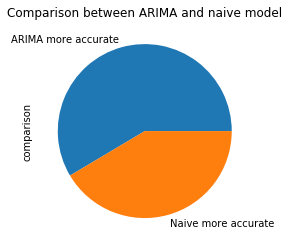

In [152]:
mse['comparison'] = np.where(mse.ARIMA_mse <= mse.naive_mse, 'ARIMA more accurate', 'Naive more accurate')

mse.comparison.value_counts().plot.pie()
plt.title('Comparison between ARIMA and naive model')

In [153]:
mse[['ARIMA_mse','naive_mse']].mean()

ARIMA_mse    0.003676
naive_mse    0.008308
dtype: float64

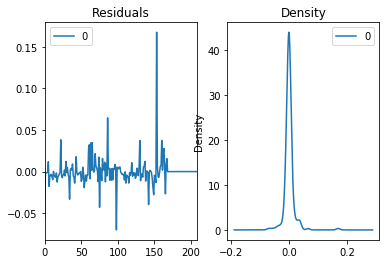

In [154]:
residuals = pd.DataFrame(predict_volatility(full_data_coy[30], print_residue=True))
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])

residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [155]:
residuals = []
for idx, coy in enumerate(full_data_coy):
    try:
        residuals.append(np.median(predict_volatility(coy, print_residue=True)))
    except:
        pass
np.mean(residuals)

-5.674920545833353e-05

### Analysis conclusion
Our model seems to perform well in predicting the future volatility of a stock in these two ways:
1. It predicts more accurately than the naive model
2. It has a lower average mean square error than the naive model
3. It does not exhibit any bias when studied on the company level

### Assumptions & limitations
Our model is built on companies with a full dataset to ensure we have the most complete dataset. This sampling may bring forth a bias as companies with a full dataset all existed (at least) since 2001. These older companies may have certain volatility characteristics that newer companies may not exhibit. Hence, our model is biased towards older companies. 

## Future works
In addition to the time series model built above, regression techniques can still be applied by studying how the correlation of the financial feature changes with respect to companies/time. For instance, the correlation between asset risk and volatility could be consistent just within companies of a certain industry, or consistent within a certain time period. Studying this correlation may very well even give us insights into why certain industry follow certain financial indicators.

# Conclusion
A huge thank you to Anu, Ram for trusting us with this project and guiding our steps along the way. We thoroughly enjoyed the process of breaking this down. Also, to our professor Douglas for the consultations we have way past office hours to give us insights to get to where we are now. 